# BCycle Austin Hourly Rental Models

This notebook concludes the BCycle Austin series of blog posts, and looks at how machine learning could be used to help the BCycle team. I'll be using weather data in addition to the station and bike information, and building models to predict how many rentals there will be at each hour of the day. This can be used to plan inventory in stations and forecast usage. Let's get started !

## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

import datetime

from bcycle_lib.utils import *

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading weather and rental data

In [2]:
bikes_df = load_bikes()
stations_df = load_stations()
weather_df = load_weather()

# Modelling bike rentals by day

In this section, I'll be using machine learning to predict how many bike rentals there are in each day. As this is a time series problem, I'll split the dataset as follows. This gives roughly a 70% training - 30% validation data split.

* Training: 1st April to 15th May (6 complete weeks of data).
* Validation: 16th May to 31st May (2 complete weeks of data).

I'll create a couple of simple baselines first, which just use previous rental numbers directly. If our machine learning models can't beat this, there's a problem! After that, I'll use time-series forecasting, and then linear regression.

In [3]:
# Convert the long-form data into wide form for pandas aggregation by hour
hourly_df = load_bike_trips()
hourly_df = hourly_df.reset_index()

hourly_df = hourly_df.pivot_table(index='datetime', values='checkouts', columns='station_id')
hourly_df = hourly_df.resample('1H').sum()
hourly_df = hourly_df.sum(axis=1)
hourly_df = pd.DataFrame(hourly_df, columns=['rentals'])
hourly_df = hourly_df.fillna(0)
hourly_df.head()

,rentals
datetime,
2016-04-01 00:00:00,5.0
2016-04-01 01:00:00,4.0
2016-04-01 02:00:00,8.0
2016-04-01 03:00:00,1.0
2016-04-01 04:00:00,2.0


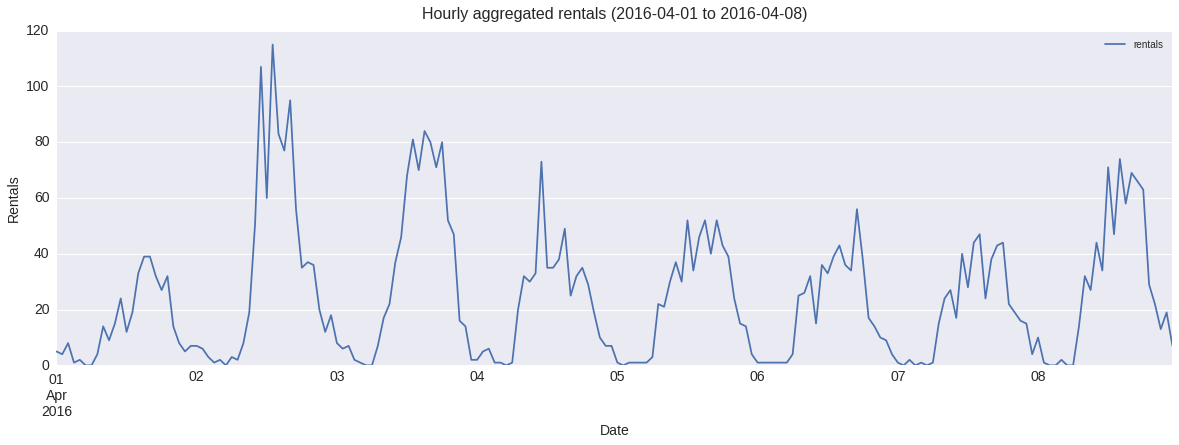

In [4]:
# Plot out the hourly bike rentals
def plot_rentals(df, cols, title, times=None):
    ''' Plots a time series data'''
    
    fig, ax = plt.subplots(1,1, figsize=(20,6))

    if times is not None:
        ax = df[times[0]:times[1]].plot(y=cols, ax=ax) # , color='black', style=['--', '-'])
        title += ' ({} to {})'.format(times[0], times[1])
    else:
        ax = df.plot(y=cols, ax=ax) # , color='black', style=['--', '-'])

    ax.set_xlabel('Date', fontdict={'size' : 14})
    ax.set_ylabel('Rentals', fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 16}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
#     ax.legend(['Hourly rentals'], fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   

plot_rentals(hourly_df, 'rentals', 'Hourly aggregated rentals', ('2016-04-01', '2016-04-08'))


In [5]:
# Wow - that looks spiky ! Let's smooth this out
def smooth_ts(df, halflife):
    '''Smooths time series data using ewma and halflife
    INPUT: Dataframe to smooth, halflife for Exponential Weighted Moving Average
    RETURNS: Smoothed dataframe
    '''
    smooth_df = df.ewm(halflife=halflife, ignore_na=False,adjust=True,min_periods=0).mean()
    smooth_df = smooth_df.shift(periods=-halflife)
    smooth_df = smooth_df.fillna(0)
    return smooth_df

# plot_df['original'] = hourly_df['rentals']
# plot_rentals(hourly_smooth_df, ['rentals', 'Hourly aggregated rentals', ('2016-04-01', '2016-04-08'))

smooth_df = smooth_ts(hourly_df, 2)

In [6]:
# First create a daily rentals dataframe, split it into training and validation

def add_time_features(df):
    ''' Extracts dayofweek and hour fields from index
    INPUT: Dataframe to extract fields from
    RETURNS: Dataframe with dayofweek and hour columns
    
    '''
    df.head()
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour.astype(str)
    df['day-hour'] = df['dayofweek'].astype(str) + '-' + df['hour']
    df['weekday'] = (df['dayofweek'] < 5).astype(np.uint8)
    df['weekend'] = (df['dayofweek'] >= 5).astype(np.uint8)
    return df

def split_train_val_df(df, train_start, train_end, val_start, val_end):
    '''Splits Dataframe into training and validation datasets
    INPUT: df - Dataframe to split
           train_start/end - training set time range
           val_start/end - validation time range
    RETURNS: Tuple of (train_df, val_df)
    '''
    train_df = df.loc[train_start:train_end,:]
    val_df = df.loc[val_start:val_end,:]
    return (train_df, val_df)

rental_time_df = add_time_features(hourly_df)
train_df, val_df = split_train_val_df(rental_time_df, 
                                      '2016-04-01', '2016-05-15', 
                                      '2016-05-16', '2016-05-31')


print('\nTraining data first and last row:\n{}\n{}'.format(train_df.iloc[0], train_df.iloc[-1]))
print('\nValidation data first and last row:\n{}\n{}'.format(val_df.iloc[0], val_df.iloc[-1]))

val_df.head()


Training data first and last row:
rentals        5
dayofweek      4
hour           0
day-hour     4-0
weekday        1
weekend        0
Name: 2016-04-01 00:00:00, dtype: object
rentals         0
dayofweek       6
hour           23
day-hour     6-23
weekday         0
weekend         1
Name: 2016-05-15 23:00:00, dtype: object

Validation data first and last row:
rentals        1
dayofweek      0
hour           0
day-hour     0-0
weekday        1
weekend        0
Name: 2016-05-16 00:00:00, dtype: object
rentals         0
dayofweek       1
hour           23
day-hour     1-23
weekday         1
weekend         0
Name: 2016-05-31 23:00:00, dtype: object


,rentals,dayofweek,hour,day-hour,weekday,weekend
datetime,,,,,,
2016-05-16 00:00:00,1.0,0,0,0-0,1,0
2016-05-16 01:00:00,0.0,0,1,0-1,1,0
2016-05-16 02:00:00,1.0,0,2,0-2,1,0
2016-05-16 03:00:00,0.0,0,3,0-3,1,0
2016-05-16 04:00:00,0.0,0,4,0-4,1,0


## Helper functions

Let's define some helper functions, which are used in the code below. We'll be running these steps multiple times for each model, so it saves copying and pasting.

In [7]:
def RMSE(pred, true):
    '''
    Calculates Root-Mean-Square-Error using predicted and true
    columns of pandas dataframe
    INPUT: pred and true pandas columns
    RETURNS: float of RMSE
    '''
    rmse = np.sqrt(np.sum((pred - true).apply(np.square)) / pred.shape[0])
    return rmse

def plot_val(val_df, pred_col, true_col, title):
    '''
    Plots the validation prediction
    INPUT: val_df - Validation dataframe
           pred_col - string with prediction column name
           true_col - string with actual column name
           title - Prefix for the plot titles.
    RETURNS: Nothing
    '''
    def plot_ts(df, pred, true, title, ax):
        '''Generates one of the subplots to show time series'''
        ax = df.plot(y=[pred, true], ax=ax) # , color='black', style=['--', '-'])
        ax.set_xlabel('Date', fontdict={'size' : 14})
        ax.set_ylabel('Rentals', fontdict={'size' : 14})
        ax.set_title(title, fontdict={'size' : 16}) 
        ttl = ax.title
        ttl.set_position([.5, 1.02])
        ax.legend(['Predicted rentals', 'Actual rentals'], fontsize=14, loc=2)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
    
    fig, ax = plt.subplots(1,1, sharey=True, figsize=(16,8))
    plot_ts(val_df, pred_col, true_col, title + ' (validation set)', ax)
    

def plot_prediction(train_df, val_df, pred_col, true_col, title):
    '''
    Plots the predicted rentals along with actual rentals for the dataframe
    INPUT: train_df, val_df - pandas dataframe with training and validataion results
           pred_col - string with prediction column name
           true_col - string with actual column name
           title - Prefix for the plot titles.
    RETURNS: Nothing
    '''
    def plot_ts(df, pred, true, title, ax):
        '''Generates one of the subplots to show time series'''
        ax = df.plot(y=[pred, true], ax=ax) # , color='black', style=['--', '-'])
        ax.set_xlabel('Date', fontdict={'size' : 14})
        ax.set_ylabel('Rentals', fontdict={'size' : 14})
        ax.set_title(title, fontdict={'size' : 16}) 
        ttl = ax.title
        ttl.set_position([.5, 1.02])
        ax.legend(['Predicted rentals', 'Actual rentals'], fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)   
    
    fig, axes = plt.subplots(2,1, sharey=True, figsize=(20,12))
    plot_ts(train_df, pred_col, true_col, title + ' (training set)', axes[0])
    plot_ts(val_df, pred_col, true_col, title + ' (validation set)', axes[1])
    
def plot_residuals(train_df, val_df, pred_col, true_col, title):
    '''
    Plots the residual errors in histogram (between actual and prediction)
    INPUT: train_df, val_df - pandas dataframe with training and validataion results
           pred_col - string with prediction column name
           true_col - string with actual column name
           title - Prefix for the plot titles.
    RETURNS: Nothing

    '''
    def plot_res(df, pred, true, title, ax):
        '''Generates one of the subplots to show time series'''
        residuals = df[pred] - df[true]
        ax = residuals.plot.hist(ax=ax, bins=20)
        ax.set_xlabel('Residual errors', fontdict={'size' : 14})
        ax.set_ylabel('Count', fontdict={'size' : 14})
        ax.set_title(title, fontdict={'size' : 16}) 
        ttl = ax.title
        ttl.set_position([.5, 1.02])
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)   
    
    fig, axes = plt.subplots(1,2, sharey=True, sharex=True, figsize=(20,6))
    plot_res(train_df, pred_col, true_col, title + ' residuals (training set)', axes[0])
    plot_res(val_df, pred_col, true_col, title + ' residuals (validation set)', axes[1])
    
    
def plot_results(train_df, val_df, pred_col, true_col, title):
    '''Plots time-series predictions and residuals'''
    plot_prediction(train_df, val_df, pred_col, true_col, title=title)
    plot_residuals(train_df, val_df, pred_col, true_col, title=title)
    
def plot_scores(df, title, sort_col=None):
    '''Plots model scores in a horizontal bar chart
    INPUT: df - dataframe containing train_rmse and val_rmse columns
           sort_col - Column to sort bars on
    RETURNS: Nothing
    '''
    fig, ax = plt.subplots(1,1, figsize=(12,8)) 
    if sort_col is not None:
        scores_df.sort_values(sort_col).plot.barh(ax=ax)
    else:
        scores_df.sort_values(sort_col).plot.barh(ax=ax)

    ax.set_xlabel('RMSE', fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.legend(['Train RMSE', 'Validation RMSE'], fontsize=14, loc=0)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

# Baseline - predict hourly rentals using median of hour

To start off with, let's just calculate the average amount of checkouts for the hour of each day in the training dataset. Then we can predict this level of rentals in the validation set and see how the RMSE looks. 

In [8]:
# Create a dataframe with median hourly rentals by day. Has 7 x 24 = 168 rows
avg_df = train_df.groupby(['hour']).median().reset_index()

train_avg_df = pd.merge(train_df, avg_df, 
                        on='hour',
                        suffixes=('_true', '_pred'),
                        how='left')
train_avg_df = train_avg_df.rename(columns ={'rentals_true' : 'true', 'rentals_pred' : 'pred'})
train_avg_df = train_avg_df[['hour', 'true', 'pred']]
train_avg_df.index = train_df.index

val_avg_df = pd.merge(val_df, avg_df, 
                      on='hour',
                      suffixes=('_true', '_pred'),
                      how='left')
val_avg_df = val_avg_df.rename(columns ={'rentals_true' : 'true', 'rentals_pred' : 'pred'})
val_avg_df = val_avg_df[['hour', 'true', 'pred']]
val_avg_df.index = val_df.index

train_avg_df.head(8)

,hour,true,pred
datetime,,,
2016-04-01 00:00:00,0,5.0,4.0
2016-04-01 01:00:00,1,4.0,2.0
2016-04-01 02:00:00,2,8.0,3.0
2016-04-01 03:00:00,3,1.0,1.0
2016-04-01 04:00:00,4,2.0,1.0
2016-04-01 05:00:00,5,0.0,0.0
2016-04-01 06:00:00,6,0.0,1.0
2016-04-01 07:00:00,7,4.0,9.0


Now we can evaluate how the median baseline performs in terms of RMSE. We use the training dataset to compute the median, and then evaluate on the validation set. 

Hourly Median Baseline RMSE - Train: 14.28, Val: 18.66


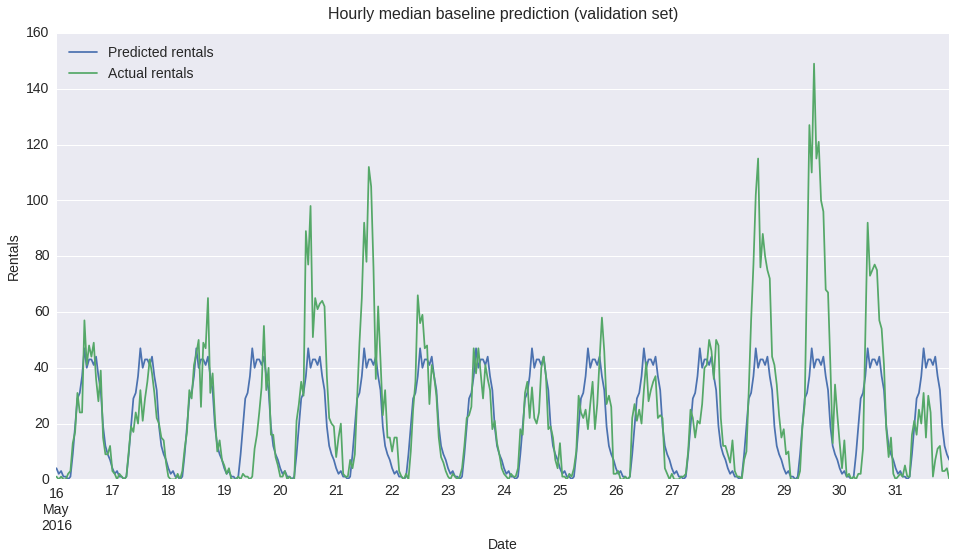

In [9]:
# Store the results of the median RMSE and plot prediction
train_avg_rmse = RMSE(train_avg_df['pred'], train_avg_df['true'])
val_avg_rmse = RMSE(val_avg_df['pred'], val_avg_df['true'])

# Store the evaluation results
scores_df = pd.DataFrame({'train_rmse' : train_avg_rmse, 'val_rmse' : val_avg_rmse}, index=['hourly_median'])

# Print out the RMSE metrics and the prediction
print('Hourly Median Baseline RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_avg_rmse, val_avg_rmse))
# plot_results(train_avg_df, val_avg_df, 'pred', 'true', title='Average baseline')
plot_val(val_avg_df, 'pred', 'true', title='Hourly median baseline prediction')

By simply taking the median of rentals at each hour, we get a good baseline RMSE on the validation set of `18.66`. The plot shows how this simple baseline doesn't account well for different behavior on the weekends, with every day predicted identically.

# Linear models - Time

Now we have some baselines to compare against, let's use a [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) model to predict the daily rentals in the last couple of weeks of the validation dataset. We'll be using the excellent [scikit-learn](http://scikit-learn.org/stable/) library, which has a wide range of [linear models](http://scikit-learn.org/stable/modules/linear_model.html) we can use. First of all, let's create some helper functions.

In [10]:
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler, scale

def reg_x_y_split(df, target_col, ohe_cols=None, z_norm_cols=None, minmax_norm_cols=None):
    ''' Returns X and y to train regressor
    INPUT: df = Dataframe to be converted to numpy arrays 
           target_col = Column name of the target variable
           ohe_col = Categorical columns to be converted to one-hot-encoding
           z_norm_col = Columns to be z-normalized
    RETURNS: Tuple with X, y, df
    '''
    
    # Create a copy, remove index and date fields
    df_out = df.copy()
    df_X = df.copy()
    df_X = df_X.reset_index(drop=True)
    X = None
    
    # Convert categorical columns to one-hot encoding
    if ohe_cols is not None:
        for col in ohe_cols:
            print('Binarizing column {}'.format(col))
            lbe = LabelBinarizer()
            ohe_out = lbe.fit_transform(df_X[col])
            if X is None:
                X = ohe_out
            else:
                X = np.hstack((X, ohe_out))
            df_X = df_X.drop(col, axis=1)
            
    # Z-normalize relevant columns
    if z_norm_cols is not None:
        for col in z_norm_cols:
            print('Z-Normalizing column {}'.format(col))
            scaled_col = scale(df[col].astype(np.float64))
            scaled_col = scaled_col[:,np.newaxis]
            df_out[col] = scaled_col
            if X is None:
                X = scaled_col
            if X is not None:
                X = np.hstack((X, scaled_col))
            df_X = df_X.drop(col, axis=1)

    if minmax_norm_cols is not None:
        for col in minmax_norm_cols:
            print('Min-max scaling column {}'.format(col))
            mms = MinMaxScaler()
            mms_col = mms.fit_transform(df_X[col])
            mms_col = mms_col[:, np.newaxis]
            df_out[col] = mms_col
            if X is None:
                X = mms_col
            else:
                X = np.hstack((X, mms_col))
            df_X = df_X.drop(col, axis=1)

    # Combine raw pandas Dataframe with encoded / normalized np arrays
    if X is not None:
        X = np.hstack((X, df_X.drop(target_col, axis=1).values))
    else:
        X = df_X.drop(target_col, axis=1)
        
    y = df[target_col].values

    return X, y, df_out

Now we can use the helper functions to create the X and y numpy arrays for use in the machine learning models

In [11]:
# Create new time-based features, numpy arrays to train model

X_train, y_train, train_df = reg_x_y_split(train_df, 
                                           target_col='rentals', 
                                           ohe_cols=['day-hour'])
X_val, y_val, val_df = reg_x_y_split(val_df, 
                                     target_col='rentals', 
                                     ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

Binarizing column day-hour
Binarizing column day-hour
X_train shape: (1080, 172), y_train shape: (1080,)
X_val shape: (384, 172), y_val shape: (384,)


The `dayofweek` categorical column is converted to a one-hot encoded set of columns (one per day of the week) and added to the features. Linear models can't use categorical values directly unlike tree-based models.
Now we can train the model, make predictions, and calculate the RMSE of the predictions. scikit-learn has a built in Mean-Square-Error function, so we can square-root this to get RMSE.

In [12]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : reg_train_rmse, 'val_rmse' : reg_val_rmse}, 
                                              index=['linreg_time']))

Now let's create another helper function, which takes all the model predictions and stores them in a common dataframe format we can re-use in many steps below.

Time regression RMSE - Train: 10.74, Val: 15.16


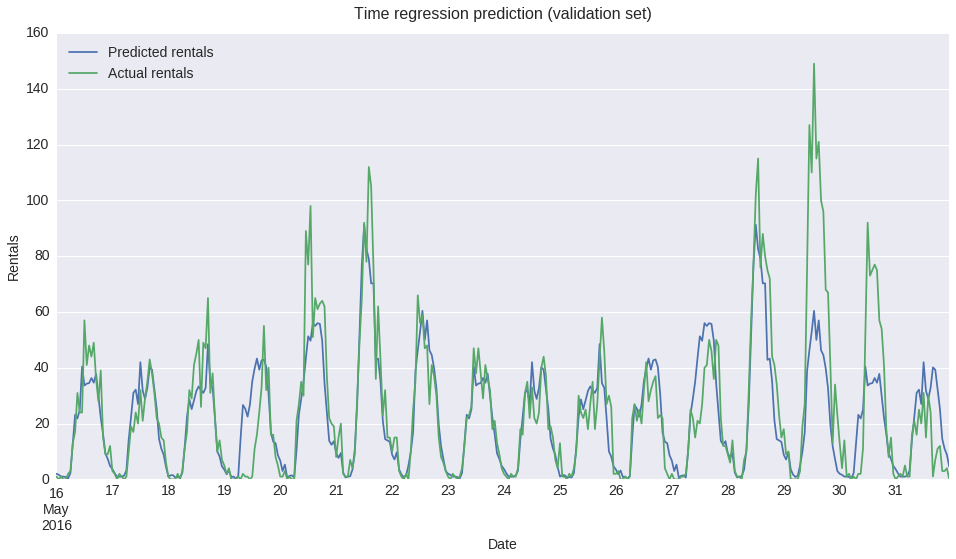

In [13]:
def df_from_results(index_train, y_train, y_train_pred, index_val, y_val, y_val_pred):
    
    train_dict = dict()
    val_dict = dict()

    train_dict['true'] = y_train
    train_dict['pred'] = y_train_pred

    val_dict['true'] = y_val
    val_dict['pred'] = y_val_pred

    train_df = pd.DataFrame(train_dict)
    val_df = pd.DataFrame(val_dict)

    train_df.index = index_train
    val_df.index = index_val
    
    return train_df, val_df
    
    
reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

print('Time regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_train_rmse, reg_val_rmse))
# plot_results(reg_result_train_df, reg_result_val_df, 'pred', 'true', title='Time regression')
plot_val(reg_result_val_df, 'pred', 'true', title='Time regression prediction')

This shows a much better result. By combining the day of the week and hour of day into a single interaction term, we've isolated hours on the weekend days separately from those during the week ! This RMSE of `15.15` is much better than the baseline.

# Linear Models - Time and Weather

To improve on the previous results, we can use the weather conditions to give the model extra information. First of all, we can do a naive approach and merge in all weather data to see how this changes the performance of the model.

In [14]:
# # Merge the training and validation datasets with the weather dataframe

def merge_daily_weather(df, weather_df):
    '''Merges the dataframes using the date in their indexes
    INPUT: df - Dataframe to be merged with date-based index
           weather_df - Dataframe to be merged with date-based index
    RETURNS: merged dataframe
    '''    

    # Extract the date only from df's index
    df = df.reset_index()
    df['date'] = df['datetime'].dt.date.astype('datetime64')
    df = df.set_index('datetime')
    
    # Extract the date field to join on
    weather_df = weather_df.reset_index()
    
    # Merge with the weather information using the date
    merged_df = pd.merge(df, weather_df, on='date', how='left')
    merged_df.index = df.index
    merged_df = merged_df.drop('date', axis=1)
    
    assert df.shape[0] == merged_df.shape[0], "Error - row mismatch after merge"
    
    return merged_df


train_weather_df = merge_daily_weather(train_df, weather_df)
val_weather_df = merge_daily_weather(val_df, weather_df)

train_weather_df.head()

,rentals,dayofweek,hour,day-hour,weekday,weekend,max_temp,min_temp,max_humidity,min_humidity,max_pressure,min_pressure,max_wind,min_wind,max_gust,precipitation,cloud_pct,fog,thunderstorm,rain
datetime,,,,,,,,,,,,,,,,,,,,
2016-04-01 00:00:00,5.0,4,0,4-0,1,0,66,51,72,42,30.17,29.76,21,8,37,0.34,62.5,0,1,1
2016-04-01 01:00:00,4.0,4,1,4-1,1,0,66,51,72,42,30.17,29.76,21,8,37,0.34,62.5,0,1,1
2016-04-01 02:00:00,8.0,4,2,4-2,1,0,66,51,72,42,30.17,29.76,21,8,37,0.34,62.5,0,1,1
2016-04-01 03:00:00,1.0,4,3,4-3,1,0,66,51,72,42,30.17,29.76,21,8,37,0.34,62.5,0,1,1
2016-04-01 04:00:00,2.0,4,4,4-4,1,0,66,51,72,42,30.17,29.76,21,8,37,0.34,62.5,0,1,1


This helper function splits the weather-based dataframe into X and y as before. Now we can see there are 26 features in the training and validation sets, compared to 9 with the basic time-based model.

In [15]:
X_train, y_train, _ = reg_x_y_split(train_weather_df, target_col='rentals', ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_weather_df, target_col='rentals', ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

Binarizing column day-hour
Binarizing column day-hour
X_train shape: (1080, 186), y_train shape: (1080,)
X_val shape: (384, 186), y_val shape: (384,)


Time and weather RMSE - Train: 9.86, Val: 14.67


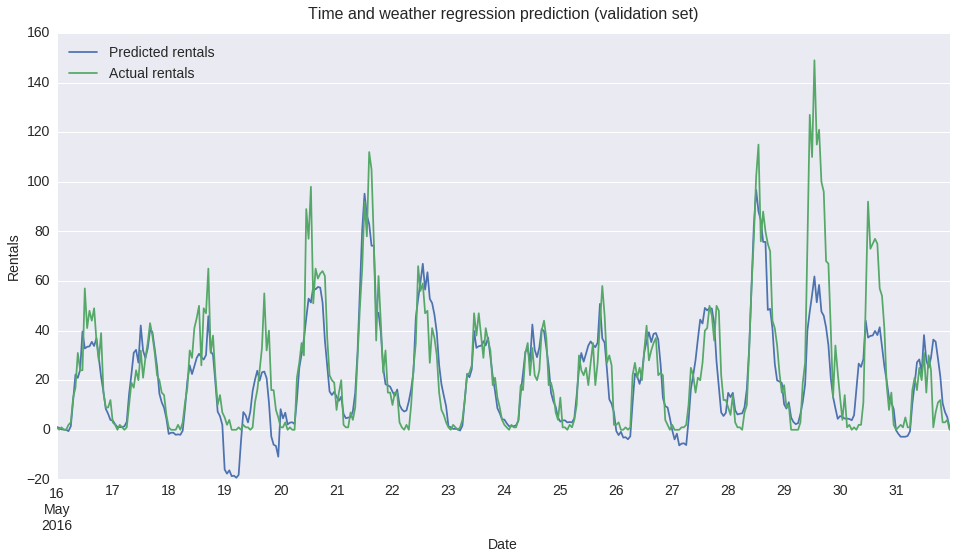

In [16]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_weather' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : reg_train_rmse, 'val_rmse' : reg_val_rmse}, 
                                              index=['linreg_time_weather']))

print('Time and weather RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_train_rmse, reg_val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

# plot_results(reg_result_train_df, reg_result_val_df, 'pred', 'true', title='Linear regression with weather')
plot_val(reg_result_val_df, 'pred', 'true', title='Time and weather regression prediction')

The RMSE from this model is better than the time-only regression model (RMSE of `14.67` vs `15.15`). There are some big gaps (19th May and 29th/30th May) though which need investigating.

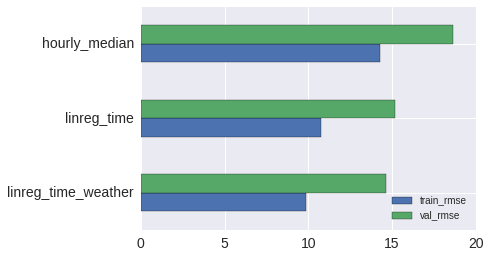

In [17]:
# print('Regression coefficients:\n{}'.format(reg.coef_))
# print('Regression residues:\n{}'.format(reg.residues_))
# print('Regression intercept:\n{}'.format(reg.intercept_))
scores_df.sort_values('val_rmse', ascending=True).plot.barh()


By adding the raw weather features into our model, we improved RMSE on the validation set from 207 (time features only) to 188 (time and weather features). But this still performs worse than the day-of-week median baseline validation RMSE of 180! Surely we should be able to improve on the baseline with more information?!

The answer is that more data (especially for linear models) is not always better. If certain features are correlated with each other, then this can confuse the model when it's trained. There are also assumptions about the statistics of the input data (that each feature comes from a Gaussian process, which are independent and identically distributed). If we violate this assumptions the model won't perform well.

# Linear Models - Time and Weather with Feature Engineering

Now we have a baseline performance with all time and weather features, we can start to work on the feature engineering part of the project. A good first step is to visualize the correlations in your dataset as-is. In general, we want to keep features which have a strong correlation with the target variable (rentals). When features are strongly correlated to others, we want to drop these.

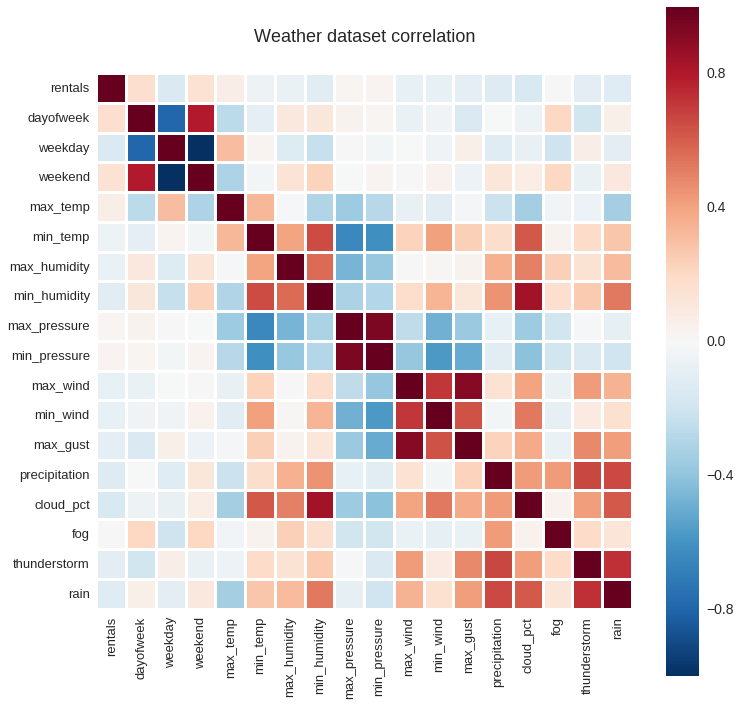

In [18]:
corr_df = train_weather_df.corr()

fig, ax = plt.subplots(1,1, figsize=(12, 12))
sns.heatmap(data=corr_df, square=True, linewidth=2, linecolor='white', ax=ax)
ax.set_title('Weather dataset correlation', fontdict={'size' : 18})
ttl = ax.title
ttl.set_position([.5, 1.05])
# ax.set_xlabel('Week ending (Sunday)', fontdict={'size' : 14})
# ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

# Linear Models - Time and Weather with Feature Normalization




In [19]:
ohe_cols = ['day-hour']
znorm_cols = ['max_temp', 'min_temp', 'max_humidity', 'min_humidity',
       'max_pressure', 'min_pressure', 'max_wind', 'min_wind', 'max_gust', 'precipitation']
minmax_cols = ['cloud_pct']
target_col = 'rentals'

X_train, y_train, train_df = reg_x_y_split(train_weather_df, target_col, ohe_cols, znorm_cols, minmax_cols)
X_val, y_val, val_df = reg_x_y_split(val_weather_df, target_col, ohe_cols, znorm_cols, minmax_cols)

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

Binarizing column day-hour
Z-Normalizing column max_temp
Z-Normalizing column min_temp
Z-Normalizing column max_humidity
Z-Normalizing column min_humidity
Z-Normalizing column max_pressure
Z-Normalizing column min_pressure
Z-Normalizing column max_wind
Z-Normalizing column min_wind
Z-Normalizing column max_gust
Z-Normalizing column precipitation
Min-max scaling column cloud_pct
Binarizing column day-hour
Z-Normalizing column max_temp
Z-Normalizing column min_temp
Z-Normalizing column max_humidity
Z-Normalizing column min_humidity
Z-Normalizing column max_pressure
Z-Normalizing column min_pressure
Z-Normalizing column max_wind
Z-Normalizing column min_wind
Z-Normalizing column max_gust
Z-Normalizing column precipitation
Min-max scaling column cloud_pct
X_train shape: (1080, 186), y_train shape: (1080,)
X_val shape: (384, 186), y_val shape: (384,)


/home/tim/anaconda3/envs/ds450_env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/tim/anaconda3/envs/ds450_env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/tim/anaconda3/envs/ds450_env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data

Time and Weather Regression RMSE - Train: 9.90, Val: 14.63


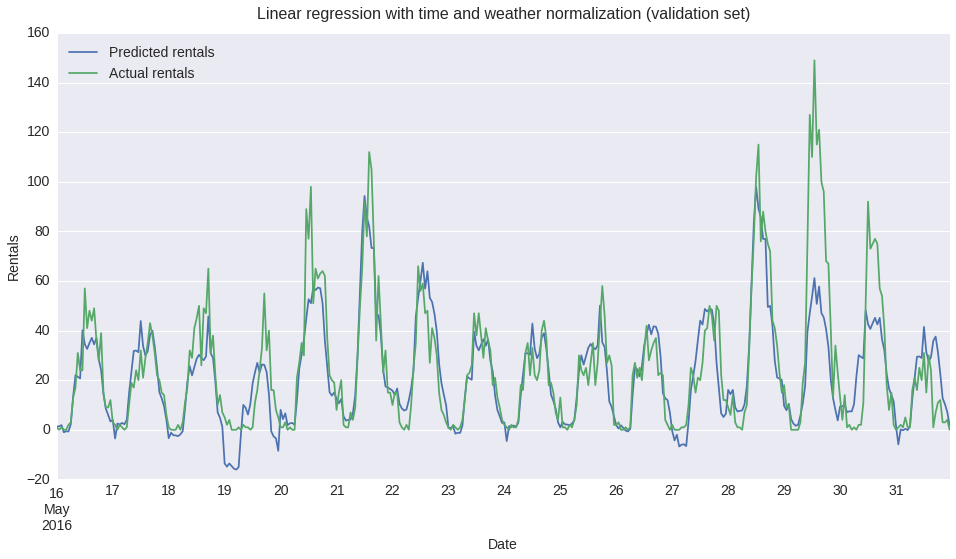

In [20]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# # Store the evaluation results
# if 'linreg_time_weather_norm' not in scores_df.index:
#     scores_df = scores_df.append(pd.DataFrame({'train_rmse' : reg_train_rmse, 'val_rmse' : reg_val_rmse}, 
#                                               index=['linreg_time_weather_norm']))

print('Time and Weather Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_train_rmse, reg_val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

# plot_results(reg_result_train_df, reg_result_val_df, 'pred', 'true', title='Linear regression with time and weather')
plot_val(reg_result_val_df, 'pred', 'true', title='Linear regression with time and weather normalization')

# Feature selection

In [21]:
# Try different values for the good columns
GOOD_COLS = ['rentals', 'max_temp', 'min_temp', 'max_gust', 'precipitation', 
        'cloud_pct', 'thunderstorm', 'day-hour']

X_train, y_train, train_df = reg_x_y_split(train_weather_df[GOOD_COLS], target_col='rentals', 
                                           ohe_cols=['day-hour'],
#                                            z_norm_cols=['max_temp', 'min_temp', 'max_gust'],
                                           minmax_norm_cols= ['cloud_pct'])

X_val, y_val, val_df = reg_x_y_split(val_weather_df[GOOD_COLS], target_col='rentals', 
                                     ohe_cols=['day-hour'],
#                                      z_norm_cols=['max_temp', 'min_temp', 'max_gust'],
                                     minmax_norm_cols=['cloud_pct'])

print('train_df columns: {}'.format(train_df.columns))
print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

Binarizing column day-hour
Min-max scaling column cloud_pct
Binarizing column day-hour
Min-max scaling column cloud_pct
train_df columns: Index(['rentals', 'max_temp', 'min_temp', 'max_gust', 'precipitation',
       'cloud_pct', 'thunderstorm', 'day-hour'],
      dtype='object')
X_train shape: (1080, 174), y_train shape: (1080,)
X_val shape: (384, 174), y_val shape: (384,)


/home/tim/anaconda3/envs/ds450_env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/tim/anaconda3/envs/ds450_env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/tim/anaconda3/envs/ds450_env/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data

Time and Weather Feature Regression RMSE - Train: 9.96, Val: 13.80


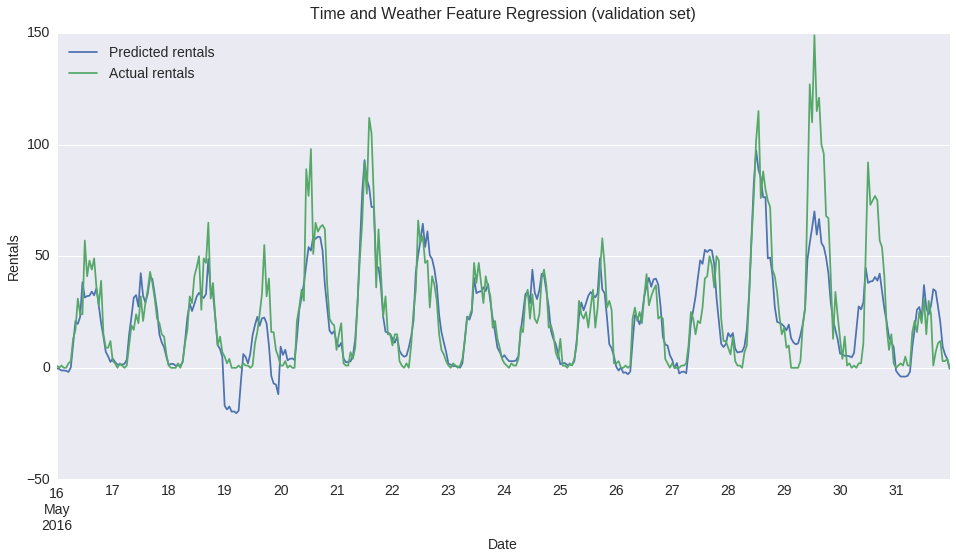

In [22]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_weather_feat' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
                                              index=['linreg_time_weather_feat']))

print('Time and Weather Feature Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

# plot_results(reg_result_train_df, reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')
plot_val(reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')

# Linear Models - Model Tuning

Now the features seem to be in good shape, we can try some different models to see which gives the best results.

,alpha,train_rmse,val_rmse
0,0.001,9.956038,13.796290
1,0.010,9.956085,13.798991
2,0.100,9.960685,13.828667
3,1.000,10.308835,14.311396
4,10.000,15.728071,19.325581


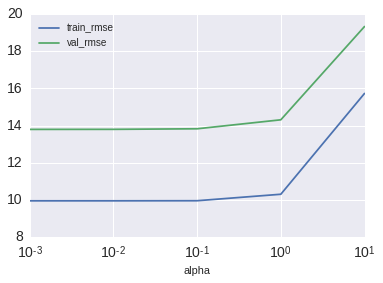

In [23]:
from sklearn.linear_model import Ridge

alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
ridge_cv_scores = dict()

for alpha in alphas:
    reg = Ridge(alpha=alpha, max_iter=10000)
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_val_pred = reg.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    ridge_cv_scores[alpha] = (train_rmse, val_rmse)


ridge_cv_df = pd.DataFrame(ridge_cv_scores).transpose().reset_index()
ridge_cv_df.columns = ['alpha', 'train_rmse', 'val_rmse']
ridge_cv_df.plot.line(x='alpha', y=['train_rmse', 'val_rmse'], logx=True)

# Store the evaluation results
if 'ridge_cv' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : ridge_cv_df['train_rmse'].min(), 
                                               'val_rmse' : ridge_cv_df['val_rmse'].min()}, 
                                              index=['ridge_cv']))
    
ridge_cv_df

,alpha,train_rmse,val_rmse
0,0.001,9.957461,13.814792
1,0.010,10.094966,14.079530
2,0.100,16.852910,20.724850
3,1.000,22.787549,26.079397
4,10.000,22.929598,26.459894


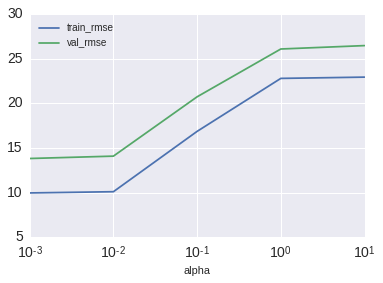

In [24]:
from sklearn.linear_model import Lasso

alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
ridge_cv_scores = dict()

for alpha in alphas:
    reg = Lasso(alpha=alpha, max_iter=10000)
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_val_pred = reg.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    ridge_cv_scores[alpha] = (train_rmse, val_rmse)

lasso_cv_df = pd.DataFrame(ridge_cv_scores).transpose().reset_index()
lasso_cv_df.columns = ['alpha', 'train_rmse', 'val_rmse']
lasso_cv_df.plot.line(x='alpha', y=['train_rmse', 'val_rmse'], logx=True)

# Store the evaluation results
if 'lasso_cv' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : ridge_cv_df['train_rmse'].min(), 
                                               'val_rmse' : ridge_cv_df['val_rmse'].min()}, 
                                              index=['lasso_cv']))
    
lasso_cv_df

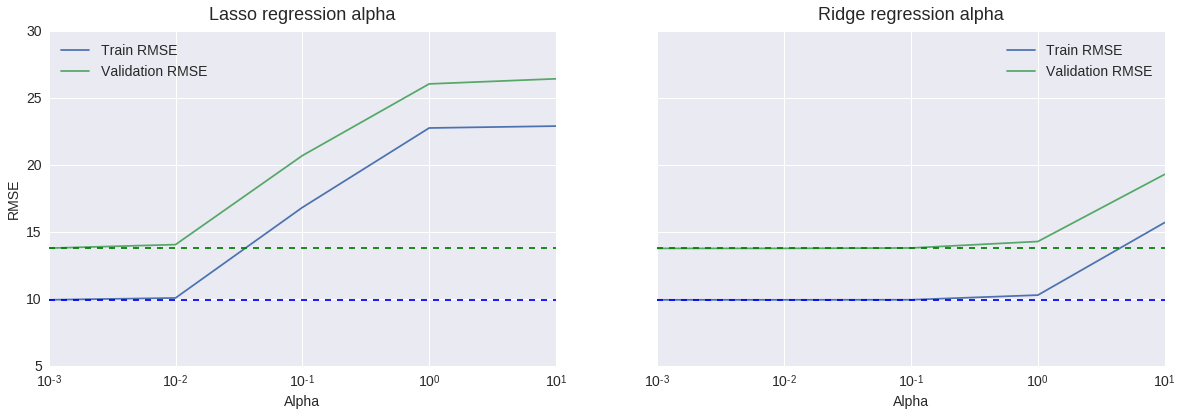

In [25]:
# Now plot side-by-side comparisons of the hyperparameter tuning, with the OLS result as a horizontal line
def plot_cv(df, title, ax):
    '''Generates one of the subplots to show time series'''
    df.plot.line(x='alpha', y=['train_rmse', 'val_rmse'], logx=True, ax=ax)
    ax.set_xlabel('Alpha', fontdict={'size' : 14})
    ax.set_ylabel('RMSE', fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   
    ax.axhline(y=scores_df.loc['linreg_time_weather_feat', 'val_rmse'], color='g', linestyle='dashed')
    ax.axhline(y=scores_df.loc['linreg_time_weather_feat', 'train_rmse'], color='b', linestyle='dashed')


    ax.legend(['Train RMSE', 'Validation RMSE'], fontsize=14, loc=0)


    
fig, axes = plt.subplots(1,2, sharey=True, figsize=(20,6))
plot_cv(lasso_cv_df, 'Lasso regression alpha', ax=axes[0])
plot_cv(ridge_cv_df, 'Ridge regression alpha', ax=axes[1])
    

,train_rmse,val_rmse
hourly_median,14.28,18.66
linreg_time,10.74,15.16
linreg_time_weather,9.86,14.67
linreg_time_weather_feat,9.96,13.80
ridge_cv,9.96,13.80
lasso_cv,9.96,13.80


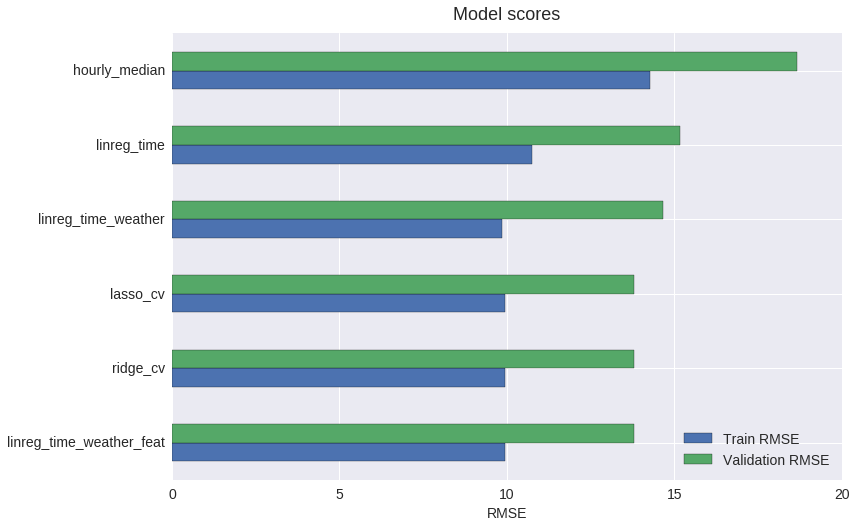

In [26]:
plot_scores(scores_df, 'Model scores', 'val_rmse')
scores_df.round(2)

# Linear Models - Review

So far we've done the following:

* Created a very basic baseline (median checkouts). This has an RMSE of 276 on the validation set.
* Improved the basic baseline (median checkouts by day of week). This RMSE is 185 on the validation data.
* Created and tuned a linear model using weather information. This RMSE is 164 on validation data.

So with the best model we have, we're off by 164 bikes per day, on average. This isn't great .. What's going on?

* We don't have very much data. By aggregating across all 50 stations, grouping by day, we end up with only 45 training examples to learn from and 16 to validate on. This is a very small amount of data to learn from, ideally we should have 1000s of examples.

* The Memorial Day holiday also causes issues for the model, because it hasn't seen one of these in the training dataset. If we had a year's worth of data to train from, we could use a dummy variable that is set to 1 on the holiday. We could also use a dummy variable for the weekend before the holiday, to flag these days up to the model.

How can we improve things? More data !

* Build individual models for each station. This increases the compute by 50x (there are 50 stations), but each of the 50 models has the same data as our single model.
* Add interaction terms and bin features



## Other models / Scratchpad

Weather Feature Regression RMSE - Train: 9.33, Val: 19.94


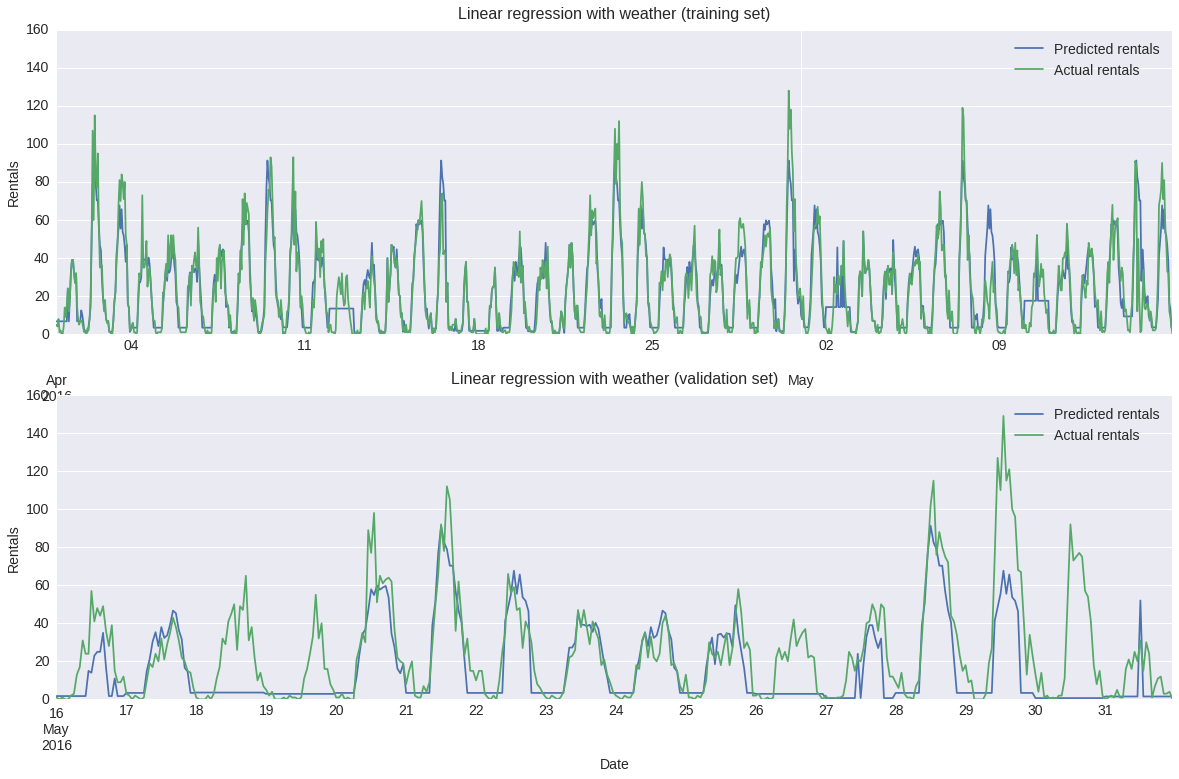

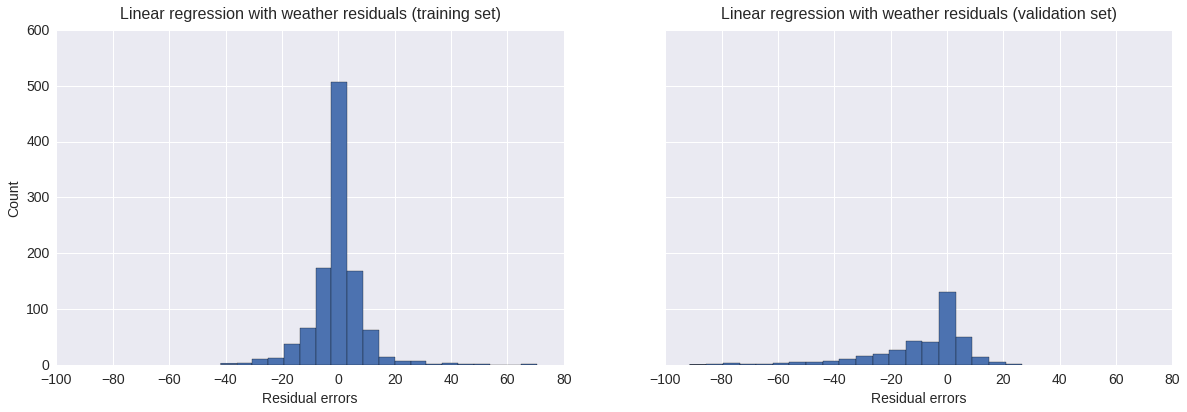

In [27]:
# Random forest

from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=100, min_samples_split=40)
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# # Store the evaluation results
# if 'linreg_time_weather_norm_feat' not in scores_df.index:
#     scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
#                                               index=['linreg_time_weather_norm_feat']))

print('Weather Feature Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_results(reg_result_train_df, reg_result_val_df, 'pred', 'true', title='Linear regression with weather')
# plot_prediction(reg_result_val_df, 'pred', 'true', title='Linear Regression with Weather Validation set prediction')


## Relationship between precipitation and rentals

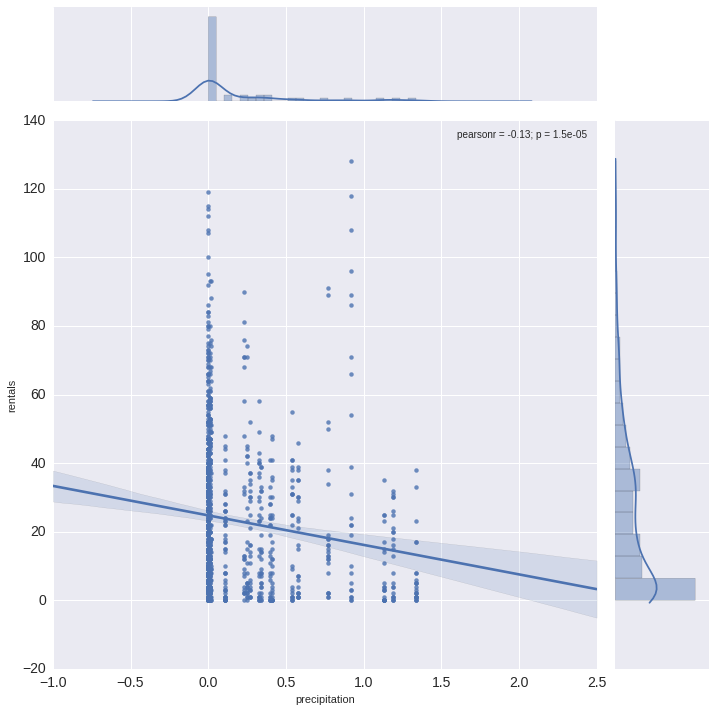

In [28]:
sns.jointplot(data=train_weather_df, x='precipitation', y='rentals', size=10, kind='reg')

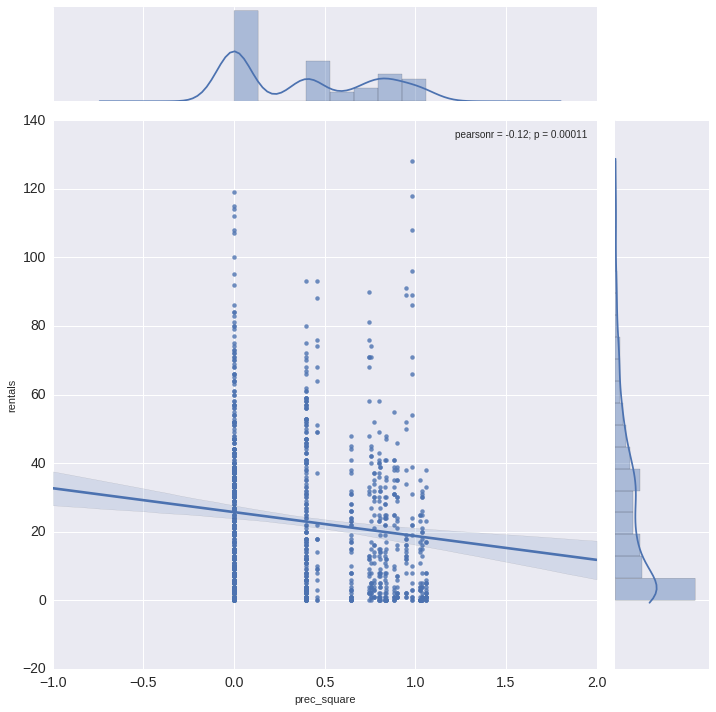

In [29]:
train_weather_df['prec_square'] = train_weather_df['precipitation'].apply(lambda x: np.power(x, 0.2))
sns.jointplot(data=train_weather_df, x='prec_square', y='rentals', size=10, kind='reg')